In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Industries'), 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-18 to 2019-07-19 - 62


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

45


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
GDXJ,60,0.439191,0.897537,0.480486,33.547521,6.657301
GDX,60,0.426329,0.780351,0.536159,31.115273,6.075660
IHI,60,0.193018,0.388818,0.476010,13.620431,4.510425
XAR,60,0.151120,0.313930,0.456099,10.809297,2.579733
FXH,60,0.124873,0.395624,0.295576,8.127107,6.013749
VHT,60,0.113859,0.360519,0.293807,7.430510,4.345281
XLV,60,0.113782,0.356047,0.297281,7.252685,3.729859
FHLC,60,0.113696,0.356947,0.296289,7.423202,4.334999
IXJ,60,0.112899,0.330566,0.317525,7.264511,3.337207


evicted FXU 0.841 0.010
evicted XLU 0.791 0.064
evicted EMLP 0.808 0.075
evicted XLB 0.746 0.177
evicted ITA 0.898 0.182
evicted IGF 0.719 0.246
evicted RYT 0.880 0.144
evicted XLP 0.707 -0.004
evicted VCR 0.850 0.033
evicted HACK 0.877 -0.141
evicted FNCL 0.752 -0.114
evicted ARKK 0.739 0.052
evicted XBI 0.613 0.014
evicted VOX 0.467 -0.155
evicted ITB 0.511 -0.132
evicted XAR 0.698 0.217
retry backlogs ['VHT', 'XLK', 'VGT', 'VFH', 'FHLC', 'VPU', 'IYW', 'VDC', 'IYH', 'IGM', 'IGV', 'XLY', 'FXL', 'VAW', 'FTEC', 'IXN', 'FXH', 'XLV', 'IYF', 'FDN', 'IYG', 'XLF', 'XT', 'IXJ', 'XLC', 'GDXJ'] at 0.905/-0.51 - 0.693
evicted XT 0.840 0.160
evicted VAW 0.693 0.220
evicted XLY 0.806 0.050
evicted IYF 0.784 -0.129
evicted VDC 0.679 -0.020
evicted XLC 0.545 -0.128
evicted IXJ 0.902 -0.079
evicted VPU 0.459 0.128
retry backlogs ['VGT', 'VHT', 'IYW', 'IGM', 'IYH', 'XLV', 'XLK', 'VFH', 'FTEC', 'FHLC', 'IGV', 'FXL', 'IXN', 'FDN', 'IYG', 'FXH', 'XLF', 'GDXJ'] at 0.910/-0.52 - 0.693
evicted XLF 0.771 -0.

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.203781,0.282426,-0.297419,0.008617,0.167677,0.360368,0.888144,0.693436,14.269852,1.824793
GDX,60.0,0.426329,0.780351,-1.240153,-0.111962,0.264382,0.877435,2.232475,0.536159,31.115273,6.075660
IHI,60.0,0.193018,0.388818,-0.919094,-0.068626,0.115745,0.485661,1.267406,0.476010,13.620431,4.510425
AMLP,60.0,0.037945,0.312374,-0.750203,-0.142325,0.030244,0.233949,0.875408,0.096067,2.423939,4.270103


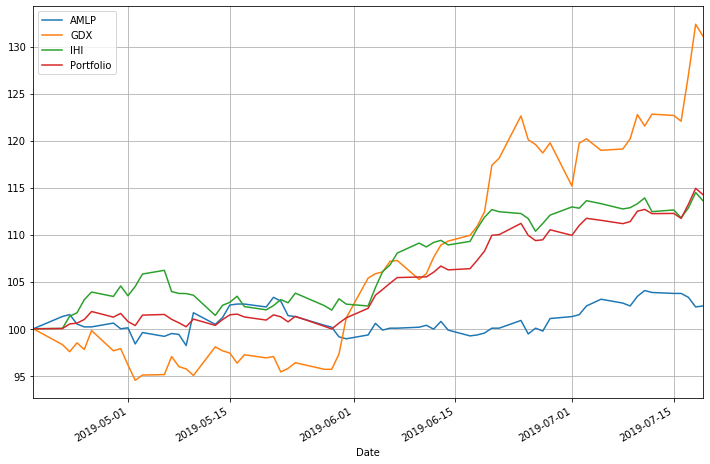

In [4]:
bounds = .16, .20
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(bounds=bounds)
quote.setup_mask(['IHI', 'AMLP', 'GDX'])
sd.update(quote.optimize_portfolio(bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)